In [ ]:
from typing import *
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from mtcnn import MTCNN

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, r2_score, confusion_matrix, average_precision_score, precision_recall_curve, auc, roc_curve,roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
import re
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


Carreguem imatges i classes del nostre dataset. Utilitzem el mètode MTCNN que utilitza xarxes neuronals per detectar la cara. 

In [ ]:

def load_dataset(dataset_path):
    data = []
    labels = []
    names = []
    characters = os.listdir(dataset_path) 
    label_map = {character: idx for idx, character in enumerate(characters)}
    
    for character in characters:
        character_path = os.path.join(dataset_path, character)
        images = os.listdir(character_path)
        
        for img_name in images:
            img_path = os.path.join(character_path, img_name)
            img = Image.open(img_path).convert("RGB")
            image_array = np.array(img)
            faces = MTCNN().detect_faces(image_array)

            if len(faces) > 0:
                x1, y1, amplada, altura = faces[0]['box']
                x2, y2 = x1 + amplada , y1 + altura
                face = image_array[y1:y2, x1:x2]
                image = Image.fromarray(face)
                data.append(image)
                labels.append(label_map[character])
                names.append(character)
            
            # Si no es detecta ninguna cara,  no ens guardem la imatge
            else:
                print(f"No s'ha detectat cara a la imatge {img_path}")
    
    return data, labels, names


In [195]:
data, labels, names = load_dataset(dataset_path="C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggleIMAGES/cast/CastHP")

No s'ha detectat cara a la imatge C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggleIMAGES/cast/CastHP\Albus Dumbledore\Micheal Gambon (11).jpg
No s'ha detectat cara a la imatge C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggleIMAGES/cast/CastHP\Lord Voldemort\Lord Voldemort(14).jpg
No s'ha detectat cara a la imatge C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggleIMAGES/cast/CastHP\Lord Voldemort\Lord Voldemort(5).jpg
No s'ha detectat cara a la imatge C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggleIMAGES/cast/CastHP\Lord Voldemort\Lord Voldemort(8).jpg
No s'ha detectat cara a la imatge C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggleIMAGES/cast/CastHP\Severus Snape\Alan Rickman (12).jpg


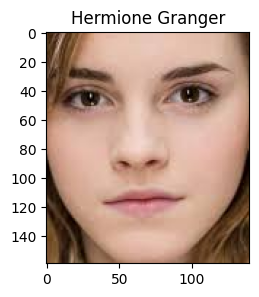

Etiqueta de la imatge: 9


In [198]:
plt.figure(figsize=(3,3))
plt.imshow(data[157])
plt.title(names[157])
plt.show()
print("Etiqueta de la imatge:", labels[157])

Fem un preprocessament de les imatges, redimensionant les imatges per que tinguin el mateix tamany i les carreguem en escala de grisos per reducir la dimensionalitat:

Text(0.5, 1.0, 'Hermione Granger')

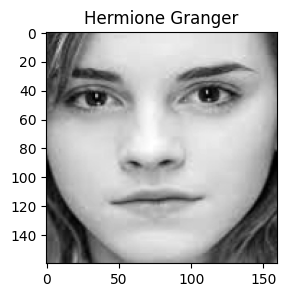

In [ ]:

def preprocess_images(images, size):
    preprocessed = []
    for img in images:
        img_resized = img.resize(size)
        img_gray = cv2.cvtColor(np.array(img_resized), cv2.COLOR_BGR2GRAY)
        preprocessed.append(np.array(img_gray))
    return preprocessed

data_preprocessed = preprocess_images(data, (160, 160))
plt.figure(figsize=(3,3))
plt.imshow(data_preprocessed[157], cmap="gray")
plt.title(names[157])


Calculem els descriptors amb el mètode HOG que mitjançant el gradient capta les vores i les estructures facials:

In [ ]:
import sklearn.svm

def extract_hog_features(images, cell_size, block_size):
    hog_features = []
    hog_images = []
    for img in images:
        feature, hog_image = hog(img/255.0, orientations=8, pixels_per_cell=(cell_size, cell_size), cells_per_block=(block_size, block_size), visualize=True, block_norm='L2-Hys')
        hog_features.append(feature)
        hog_images.append(hog_image)
    return np.array(hog_features), np.array(hog_images)


"\nmax_val = 0\nfor kernel in ('linear', 'poly', 'rbf'):\n    for cell_size in range(5,15):\n        for block_size in range(1,5):\n            features = extract_hog_features(data_preprocessed, cell_size, block_size)\n            X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(\n                    features, labels, test_size=0.25, stratify=labels, random_state=99\n                )\n            X_norm_train_2 = sc.fit_transform(X_train_2)\n            X_norm_test_2 = sc.fit_transform(X_test_2)\n            SVM = sklearn.svm.SVC(kernel=kernel)\n            SVM.fit(X_norm_train_2, y_train_2)\n            y_pred_test_2 = SVM.predict(X_norm_test_2)\n            accuracy = accuracy_score(y_test_2, y_pred_test_2)\n            if accuracy > max_val:\n                Final_kernel = kernel\n                Final_cell = cell_size\n                Final_block = block_size\n                max_val = accuracy\n\nprint(max_val)\nprint(Final_kernel)\nprint(Final_cell)\nprint(Final_block

In [289]:
hog_features, hog_images = extract_hog_features(data_preprocessed, 16, 2)

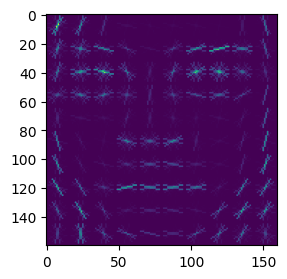

In [290]:
plt.figure(figsize=(3,3))
plt.imshow(hog_images[157])

Ja que amb el mètode HOG obtenim un vector amb moltes característiques, apliquem PCA per reduïr la dimensionalitat i així eliminar redundàncies:

In [291]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100, random_state=1)
hog_features_reduced = pca.fit_transform(hog_features)

Fem una primera classificació amb mètodes (AQUI FALTA FER GRID SEARCH I TROBAR EL MILLOR MÈTODE PQ VAN BÉ SVC Y LOGISTIC, TMB HEM D MIRAR HYPERPARAMETRES)

In [ ]:
svm_clf = SVC(kernel='rbf', gamma='scale', C= 10, random_state=42)
svm_clf = LogisticRegression(penalty='l2')

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
                    hog_features_reduced, labels, test_size=0.25, stratify=labels, random_state=99
                )

svm_clf.fit(X_train_2, y_train_2)
y_pred_test_2 = svm_clf.predict(X_test_2)
y_pred_train_2 = svm_clf.predict(X_train_2)

accuracy_test2 = accuracy_score(y_test_2, y_pred_test_2)
accuracy2_train2 = accuracy_score(y_train_2, y_pred_train_2)
print(accuracy_test2)
print(accuracy2_train2)

0.759493670886076
1.0


Fem CrossValidation per evaluar el rendiment en diferents particions de les dades:

In [293]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

scores = cross_val_score(svm_clf, hog_features_reduced, labels, scoring='accuracy', cv=cv)

print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

SVM MEAN  Accuracy:  62.74%
Standard deviation:  8.629%


Ara provem amb els descriptors de LBP que capten les textures:

In [ ]:
from skimage import feature

def compute_lbp_features(images, radius=1, n_points=8, grid_x=10, grid_y=10):
    descriptors = []
    all_histograms = []
    lbp_images = []
    for image in images:
        lbp_image = local_binary_pattern(image, n_points, radius, method="uniform")
        lbp_images.append(lbp_image)

        h, w = image.shape
        cell_h, cell_w = h // grid_y, w // grid_x
        
        descriptor_vector = []
        histograms = []

        for i in range(grid_y):
            for j in range(grid_x):
                cell = lbp_image[i * cell_h : (i + 1) * cell_h, j * cell_w : (j + 1) * cell_w]
                
                hist, _ = np.histogram ( cell.ravel(), 
                    bins=np.arange(0, n_points + 3), 
                    range=(0, n_points + 2), density=True )
                
                histograms.append(hist)
                descriptor_vector.extend(hist) 
        
        descriptors.append(np.array(descriptor_vector))
        all_histograms.append(histograms)
    
    return lbp_images, descriptors, all_histograms


radius = 2
n_points =  8 * radius
lbp_images_data, lbp_features_data, hist_data = compute_lbp_features(data_preprocessed, radius, n_points)


Observem el histograma de frequencies, que reflexa la distribució de patrons LBP en una cel·la específica d'una imatge. 
L'eix X representa els valors possibles dels patrons LBP dins de la cel·la, aquests valors (índexs) van des de 0 fins a
n_points + 2, on és el nombre de punts en el veïnatge circular utilitzat per calcular el LBP (en aquest cas, 16). L'últim valor es un patró no uniforme, que captura aquells píxels que no s'ajustan a patrons uniformes.

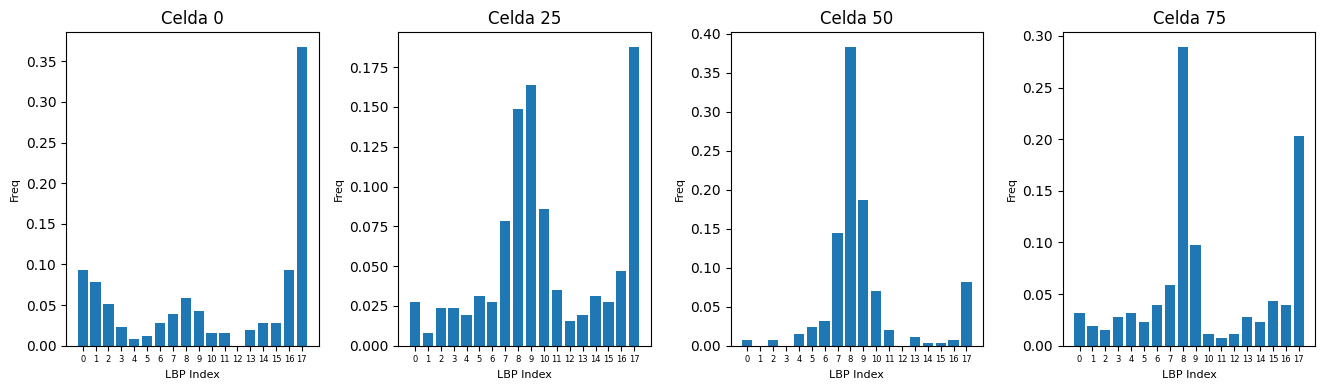

In [ ]:
i=0
plt.figure(figsize=(20, 4))
for cell_index in range(0,100,25):
    plt.subplot(1, 6, i+1)  # Ajusta el número de filas/columnas según grid_x y grid_y
    plt.bar(range(len(hist_data[157][cell_index])), hist_data[157][cell_index])
    plt.title(f"Cel·la {cell_index}")
    plt.xticks(range(len(hist_data[157][cell_index])), fontsize=6)
    plt.xlabel("LBP Index", fontsize=8)
    plt.ylabel("Freq", fontsize=8)
    i+=1
plt.tight_layout()
plt.show()


Per obtenir una visió global, sumem les frequencies de totes las cel·les d'una imatge per obtenir un únic histograma per imatge. Aqui, per exemple, agafem les 10 primeres imatges que corresponen al mateix personatge, Albus Dumbledore:

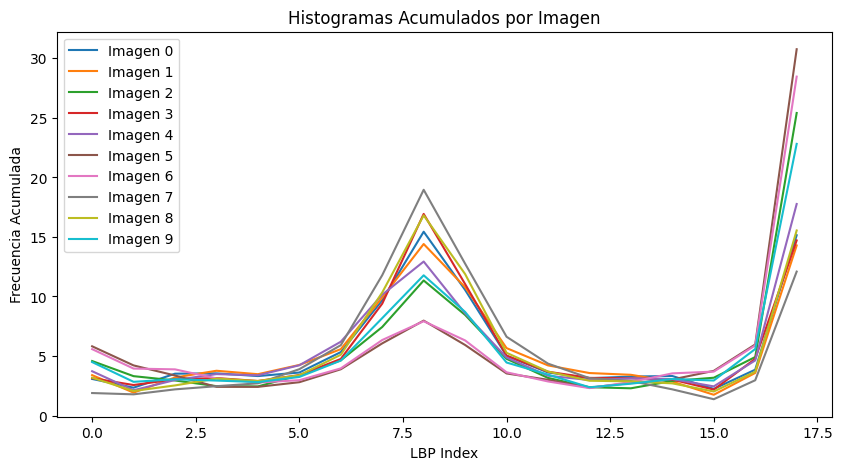

In [ ]:
cumulative_histograms = []
for histograms in hist_data:
    cumulative_hist = np.sum(histograms, axis=0) 
    cumulative_histograms.append(cumulative_hist)

plt.figure(figsize=(10, 5))
for i, cumulative_hist in enumerate(cumulative_histograms[:10]):
    plt.plot(range(len(cumulative_hist)), cumulative_hist, label=f"Imagen {i}")
plt.title("Histogrames Acumulats per imatge")
plt.xlabel("LBP Index")
plt.ylabel("Frequencia Acumulada")
plt.legend()
plt.show()


Text(0.5, 1.0, 'Hermione Granger')

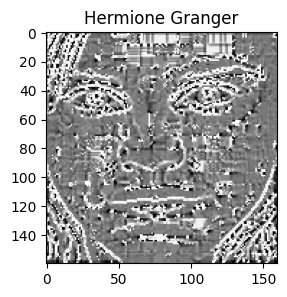

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(lbp_images_data[157], cmap="gray")
plt.title(names[157])

Fem CrossValidation:

In [ ]:
sc = StandardScaler()

X_norm = sc.fit_transform(lbp_features_data)

classifier = LogisticRegression() 

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
skf_scores = cross_val_score(classifier, X_norm, labels, scoring='accuracy', cv = skf)
gs = GridSearchCV(classifier, {'C': [0.01, 0.1, 1, 10, 100]}, scoring = 'accuracy', cv = skf)
gs.fit(X_norm, labels)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy')

In [369]:
print("Mitjana accuracy amb Stratified: ", np.mean(skf_scores))
print("Millor parametre amb Stratified: ", gs.best_params_)
print("Millor accuracy  amb Stratified: ",gs.best_score_)

Mitjana accuracy amb Stratified:  0.5473214285714286
Millor parametre amb Stratified:  {'C': 0.1}
Millor accuracy  amb Stratified:  0.5535714285714286


1.0
0.6075949367088608


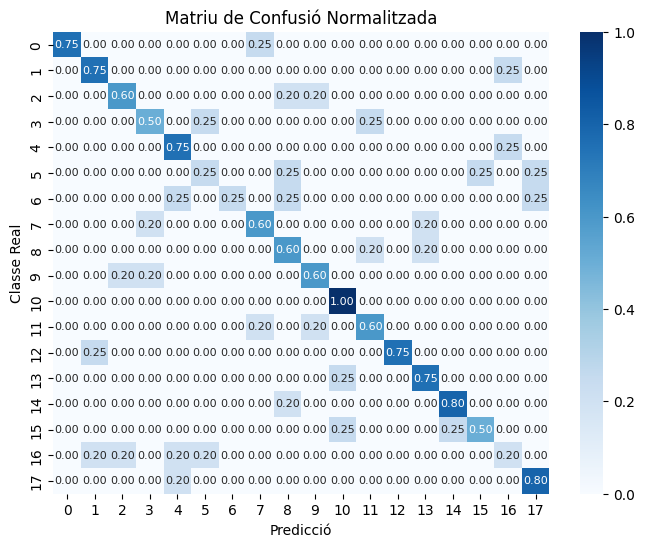

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer
from sklearn.preprocessing import Normalizer

X_train, X_test, y_train, y_test = train_test_split(
        lbp_features_data, labels, test_size=0.25, stratify=labels, random_state=99
    )

sc = StandardScaler()

X_norm_train = sc.fit_transform(X_train)
X_norm_test = sc.fit_transform(X_test)

classifier = LogisticRegression()

classifier.fit(X_norm_train, y_train)
y_pred_train = classifier.predict(X_norm_train)
y_pred_test = classifier.predict(X_norm_test)

acc_train = accuracy_score(y_train, y_pred_train )
acc_test = accuracy_score(y_test, y_pred_test)


print(acc_train)
print(acc_test)


cm = confusion_matrix(y_test, y_pred_test, normalize='true')
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 8}) 
plt.title("Matriu de Confusió Normalitzada")
plt.xlabel("Predicció")
plt.ylabel("Classe Real")
plt.show()